# sobre o gap de tempo necessário para atualizar:

Primeiro um algoritmo bem básico de regressão com dados de algum ano, como 1996 (ser o mais antigo nesse caso é bom), e ver ao longo dos anos, se a qualidade dos resultados se mantém e se é possível determinar quando ele se torna inviável.

Nesse caso uma regressão bem simples, usando dados tabulares (gorduras, calorias e proteínas), determinar a quantidade de sódio.

In [83]:
%pylab inline

import pandas as pd
import seaborn as sns
import scipy.stats as stats
import gensim
from sklearn.svm import SVC
from sklearn import metrics
from tqdm.notebook import tqdm
from sqlalchemy import create_engine

engine = create_engine('sqlite:///../recept.db')

style.use("material_darker")
figsize(10, 10)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['axis']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
df = pd.read_sql_query("""
            SELECT recept.id, recept.date, recept.calories,
                recept.fat, recept.protein, recept.rating, recept.sodium
            FROM recept""",
                       engine,  parse_dates=['date']
                      )

In [3]:
df.date = df.date.map(lambda x:x.strftime("%Y"))
df_group_year = df.groupby("date")
# df_features = df_group_year.get_group("1997")

<BarContainer object of 17 artists>

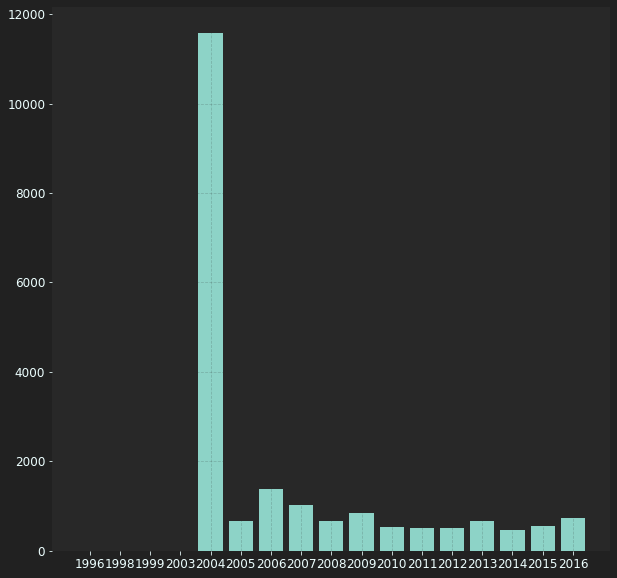

In [4]:
qnt_receitas = list(map(lambda x:len(x), df_group_year.groups.values()))
anos = df_group_year.groups.keys()

bar(x=anos, height=qnt_receitas)

In [5]:
df_features = df_group_year.get_group("2005")

Mudando os planos para 2005 em diante devido a quantidade de receitas disponíveis...

In [6]:
df_features.describe()

,id,calories,fat,protein,rating,sodium
count,661.000000,581.000000,580.000000,580.000000,661.000000,581.000000
mean,10257.193646,482.571429,26.986207,21.943103,3.959909,654.060241
std,5766.688136,469.658772,35.290404,35.212288,0.989241,1135.977899
min,42.000000,2.000000,0.000000,0.000000,0.000000,1.000000
25%,5473.000000,206.000000,9.000000,4.000000,3.750000,106.000000
50%,10503.000000,357.000000,19.000000,9.000000,4.375000,359.000000
75%,15435.000000,607.000000,35.000000,30.000000,4.375000,913.000000
max,20128.000000,5656.000000,599.000000,372.000000,5.000000,16813.000000


In [7]:
df_features = df_features.dropna()

In [8]:
features = df_features[["fat", "calories", "sodium", "protein", "rating"]]

<AxesSubplot:>

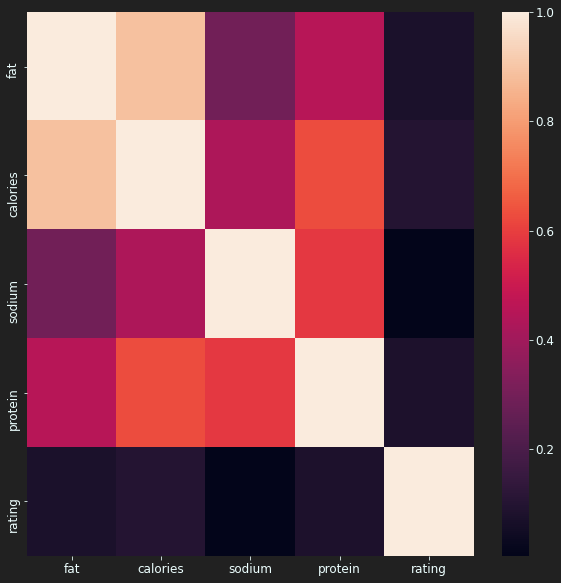

In [9]:
sns.heatmap(features.corr())

In [10]:
features.pop("rating");

removendo rating (baixíssima correlação com o resto)...

<AxesSubplot:>

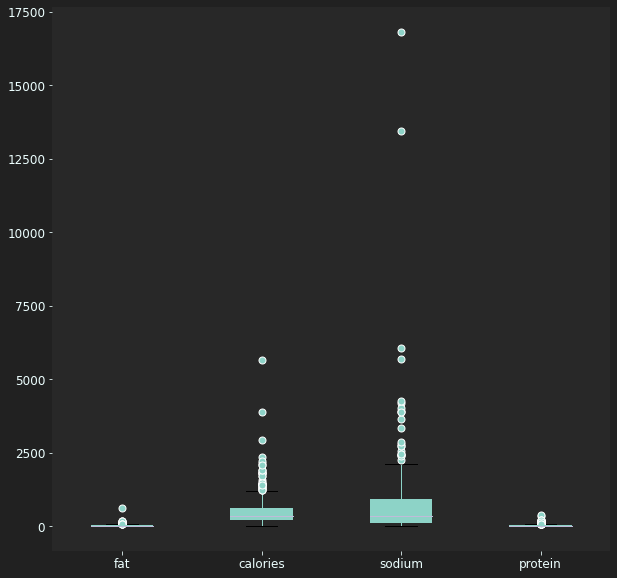

In [11]:
features.plot.box()

muito outliers... utilizando método interquartile

In [12]:
def interquartile(df):
    
    Q1 = df.quantile(q=.25)
    Q3 = df.quantile(q=.75)
    IQR = df.apply(stats.iqr)

    return df[~((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).any(axis=1)]

features = interquartile(features)

<AxesSubplot:>

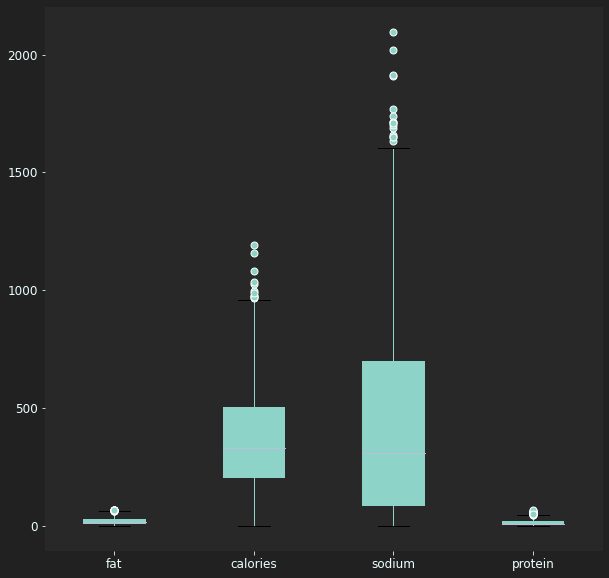

In [13]:
features.plot.box()

In [14]:
df_features[["fat", "calories", "sodium", "protein"]] = features

## Treinamento e comparações ao longo do tempo

In [51]:
df_train = df_features.dropna()

X_train = df_train[["calories", "fat", "protein"]]
Y_train = df_train.sodium

In [88]:
from sklearn.svm import SVR
svr = SVR(kernel="linear")
svr.fit(X_train, Y_train)

SVR(kernel='linear')

In [89]:
svr.score(X_train, Y_train)

0.3729624682471039

In [90]:
def pipeline(df_group_year, year):
    features = df_group_year.get_group(f"{year}")[["calories", "fat", "protein", "sodium"]].dropna()
    features = interquartile(features)
    X = features[["calories", "fat", "protein"]]
    Y = features.sodium
    return X, Y

In [91]:
x_2010, y_2010 = pipeline(df_group_year, 2016)

In [92]:
pred = svr.predict(X_train)
metrics.mean_squared_error(Y_train, pred)

129946.06727059605

In [95]:
scores = {
    "variance":[],
    "mean absolute error": [],
    "R2":[]
}


years = []
for year in list(df_group_year.groups.keys())[3:]:
    X, Y = pipeline(df_group_year, year)
    pred = svr.predict(X)
    scores["variance"].append(
        metrics.explained_variance_score(Y, pred),
    )
    scores["mean absolute error"].append(
        metrics.mean_squared_error(Y, pred, squared=False),
    )
    scores["R2"].append(
        metrics.r2_score(Y, pred),
    )
    
    
    
    print(year, scores["R2"][-1])
    years.append(year)

2003 0.9807991226133848
2004 0.13091547842041396
2005 0.3729624682471039
2006 0.2850692296705496
2007 0.09167409910637225
2008 0.2247190383943376
2009 0.2137515742450823
2010 0.2087623202568638
2011 0.08539188674836728
2012 0.17505445151143262
2013 0.15058047854540846
2014 0.20809779598589617
2015 0.23409699702112963
2016 0.23463263640659404


<ipython-input-94-3c1d7ed2d640>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(years)


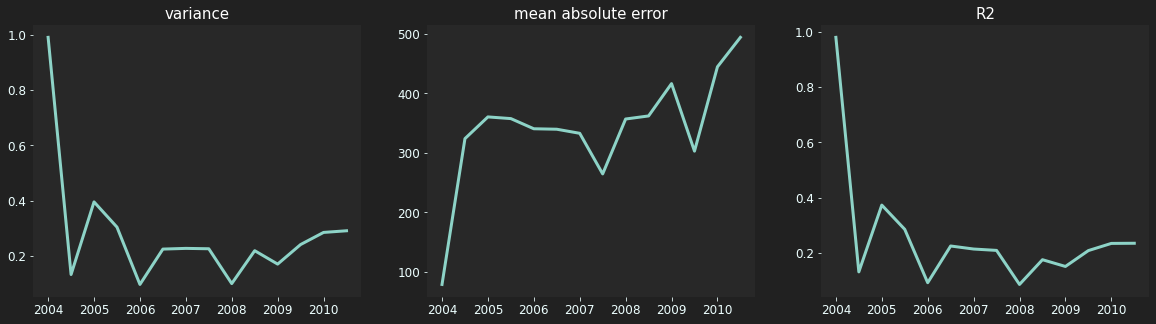

In [94]:
fig, ax = subplots(1, 3, figsize=(20, 5))

for axis, metric in zip(ax, scores.keys()):
    axis.plot(scores[metric])
    axis.set_xticklabels(years)
    axis.set_title(metric)

Este regressor realmente ficou muito ruim, mas o objetivo dele não era ser bom, mas explorar o fator temporal, analisando como os resultados de um algoritmo treinado varia ao longo do tempo pois a realidade em sua volta muda enquanto ele continua reproduzindo o que foi aprendido no passado

O gráfico acima pode estar mostrando 2 coisas diferentes ao mesmo tempo:

1. com o tempo o algoritmo fica de fato defasado ao ponto de ter um resultado inviável para o contexto de 2016, isso fica muito evidente com o erro médio absoluto
2. pode haver ciclos na relação entre os dados trabalhados, esses picos para baixo dos gráficos, nesses períodos é bem provável que exista uma falsa sensação que o algoritmo continue funcional e lembrando que tratei aqui de pouquíssimos dados sem uma tão boa análise prévia de todas as 

Curiosamente, quase que como alheio a isso a variância mostra uma diversidade cada vez menor, o que falsamente pode dar a sensação que a realidade se alinhou ao algoritmo treinado quando na realidade isso é desmentido ao longo do tempo, além de ser uma coisa muito improvável já que numa situação real raríssimas vezes ocorreria um golpe de sorte desses. Fica evidente a dispartidade entre os resultados no último ano e isso as três métricas acima concordam, há uma tendência crescente na distância entre o apresentado pelo algoritmo e os dados.